#Three layers autoencoder
This notebook test the theoretical results following the study of a three layers autoencoder found in **section 4.3** in [this paper](https://github.com/HeleneMaxcici/Autoencoder-Study/blob/master/Autoencoder_Study_02-01-2022.pdf). 

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer

from ae_functionalities import stepfunctions, AutoEncoder

##Data

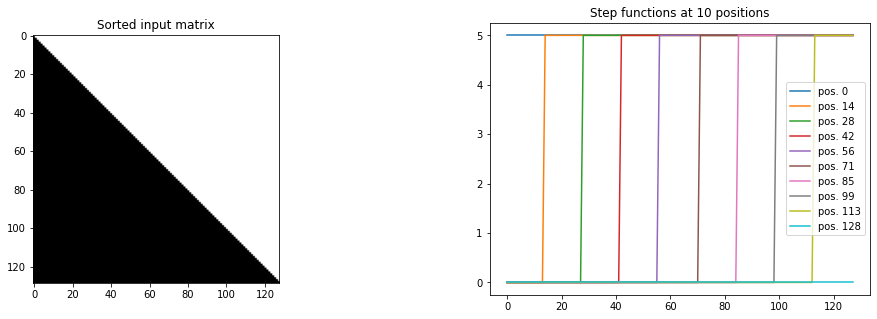

In [2]:
# Creating the dataset
left_amp = [0] 
right_amp = [5] #step functions of amplitude 1

n=128 #dimension of the step functions

X_test = stepfunctions(n, left_amp, right_amp) #sorted matrix of step functions

#permuting samples
r = torch.randperm(X_test.shape[0])
X = X_test[r,:]

#visualization of the matrix
plt.figure(figsize = (15,5))

plt.subplot(1,3,1)
plt.imshow(X_test, cmap='gray')
plt.title("Sorted input matrix")

plt.subplot(1,2,2)
for i in np.linspace(0,n,10,dtype=int):
  plt.plot(X_test[i], label=f"pos. {i}");
plt.title("Step functions at 10 positions")
plt.legend()

## Implementation of handcrafted solution with linear encoder

The configuration of an exact solution is based on finding the parameters of the decoder that make $A^{[2]}$ full rank and choosing an arbitrary $U^{[3]}$ satisfying **lemma 4.4.**

- **Encoder:**

  As a first step, we will take $z^{(i)}$ to be linear in function of $\theta^{(i)}$. Thus, we consider the following parameters
  \begin{align}
    W^{[1]} &= \frac{1}{5}[-1,...,-1]\\
    b^{[1]} &= n+1 = 129
  \end{align}

- **Decoder:**

  Following the proof of **lemma 4.6.**, we choose $W^{[2]}$ and $\mathbf b^{[2]}$ in a way to make $A^{[2]}$ full rank. 
  
  - $W^{[2]} = [-1,-1,...,-1]$
  
  - $b^{[2]} = [1.5,2.5,...,127.5]$

  Then, we choose $U^{[3]}$
   \begin{equation}
    U^{[3]} =
    \begin{bmatrix}
        C & C &  \dots  & C & C \\
        t & C &  \dots  & C & C \\
        t & t &  \dots  & C & C \\
        \vdots & \vdots &  \ddots & \vdots & \vdots \\
        t & t & \dots  & t & C \\
        t & t & \dots  & t & t
    \end{bmatrix}
\end{equation}

  with $t=-3$ and $C=5$.

Now we have all we need to compute the rest of the parameters.

In [3]:
#Computing the weights
n=128
#Layer 1
W1 = -torch.ones(1, n)/5
b1 = 129*torch.ones(1, 1)

print("W1:\n", W1)
print("b1:\n",b1)

#Layer 2
W2 = -torch.ones(n, 1)
b2 = torch.arange(1,n+1) + 0.5

print("W2:\n", W2.T)
print("b2:\n",b2)

A2 = ((torch.triu(torch.ones(n, n))@torch.triu(torch.ones(n, n))) - 0.5) * torch.triu(torch.ones(n, n))

print("A2:\n",A2)

#Layer 3

U3 = -3 * torch.tril(torch.ones(n, n),diagonal=-1) + 5 * torch.triu(torch.ones(n, n))

print("U3:\n", U3)

W3 = (torch.linalg.inv(A2)@U3).T

print("W3:\n", W3)

W1:
 tensor([[-0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000,
         -0.2000, -0.20

In [4]:
#Setting the computed weights for a linear encoder 
class fixed_Encoder(nn.Module):
  
  def __init__(self):
    super(fixed_Encoder, self).__init__()
    
    self.W1 = W1

    self.b1 = b1
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1, self.b1)
    
    return self.code

class fixed_Decoder(nn.Module):

  def __init__(self):
    super(fixed_Decoder, self).__init__()
    
    self.W2 = W2
    
    self.b2 = b2
    
    self.W3 = W3
    
  def forward(self, code):
    
    self.a2 = F.relu(F.linear(code, self.W2, self.b2))
    self.y = F.relu(F.linear(self.a2, self.W3))
    
    return self.y

In [5]:
n=128
#initializing the encoder and decoder
encoder = fixed_Encoder()
decoder = fixed_Decoder()

ae = AutoEncoder(encoder, decoder)

Text(0, 0.5, 'code')

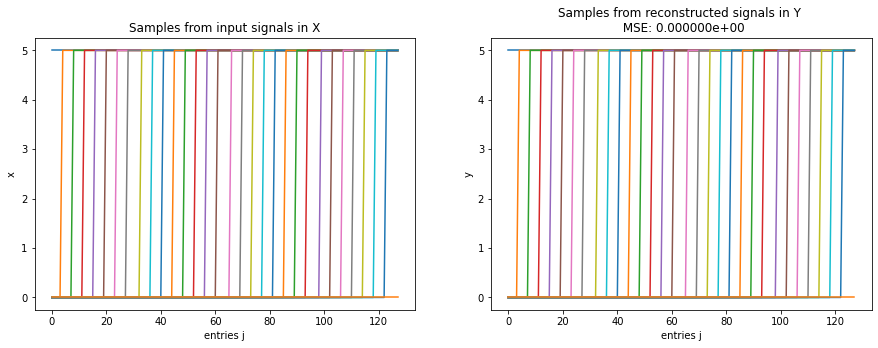

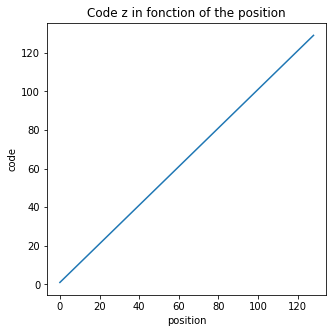

In [6]:
#Computing reconstructions and MSE loss
Y = ae.forward(X_test)
MSE_sigm_sol = torch.mean((Y-X_test)**2)

#Visualising the results
fig1 = plt.figure(figsize = (15,5))

axes = fig1.subplots(1,2)

for i in np.linspace(0, n, 32, dtype=int):
  axes[0].plot(X_test[i,:], label = i)
  axes[1].plot(Y[i].detach().numpy().ravel())

axes[0].set_title("Samples from input signals in X")
axes[1].set_title("Samples from reconstructed signals in Y \n MSE: {:e}".format(MSE_sigm_sol))

axes[0].set_xlabel("entries j")
axes[0].set_ylabel("x")

axes[1].set_xlabel("entries j")
axes[1].set_ylabel("y")

#Visualising the code in function of the position
fig2 = plt.figure(figsize = (5,5))
z = ae.encoder.code
plt.plot(z.detach().numpy())

plt.title("Code z in fonction of the position")
plt.xlabel("position")
plt.ylabel("code")

**Comment:**

- The null MSE indicate a perfect reconstruction. Thus the existence of a solution with a linear encoding is verified.
- There exist a solution that can reconstruct the $n+1$ step function including the signal identically equal to $0$.

### Generate other solutions
In **proposition 4.10**, we mentioned that, for a fixed encoder, if $(W^{[2]}, \mathbf b^{[2]}, W^{[3]})$ is a solution, then for any positive diagonal matrix $D$, $(DW^{[2]}, \mathbf b^{[2]}D, W^{[3]}D^{-1})$ is also a solution. Let's test it by choosing $D$ randomly.

In [7]:
#Sampling D
diag = torch.rand(n) * 10

if 0 in diag:
  diag[diag==0] = 1

D = torch.diag(diag)
print("D:\n", D)

D:
 tensor([[7.6361, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0054, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.2460,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 5.9932, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 9.8107, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 5.9954]])


In [8]:
#Applying D on the previous solution

W2_p = D@W2

b2_p = b2@D

W3_p = W3@torch.linalg.inv(D)

print("New W2:\n",W2_p.T)
print("New b2:\n",b2_p)
print("New W3:\n",W3_p)

New W2:
 tensor([[-7.6361, -1.0054, -1.2460, -6.7171, -4.0904, -4.1244, -7.6758, -6.6259,
         -5.2488, -3.5915, -5.8631, -6.1645, -6.8658, -3.3744, -7.4177, -4.7916,
         -4.5114, -0.5034, -8.5838, -6.3225, -6.6923, -3.5641, -3.0798, -2.6950,
         -3.4941, -1.1786, -1.5453, -7.3042, -7.9404, -8.9906, -3.1708, -6.2167,
         -1.8725, -9.5795, -2.7922, -2.4179, -1.0808, -8.6931, -6.7974, -2.5425,
         -7.0065, -2.6976, -9.3953, -1.8933, -2.8015, -7.9472, -4.3492, -3.1825,
         -9.6479, -3.3497, -9.7663, -9.1364, -3.9091, -6.8416, -5.6171, -2.1117,
         -7.0003, -1.9375, -1.8649, -5.7971, -8.8066, -2.3062, -3.2736, -3.3836,
         -4.9769, -2.9936, -7.0920, -1.4831, -4.9486, -9.0805, -5.9550, -2.8622,
         -6.6512, -6.0122, -4.6535, -7.2528, -5.2952, -2.8729, -6.9932, -2.7801,
         -4.6253, -0.3696, -4.2952, -0.5633, -6.6906, -0.0631, -8.6427, -5.6014,
         -9.6228, -0.9665, -8.1443, -1.8481, -2.0236, -5.8343, -7.2661, -0.4968,
         -1.5679, -

In [9]:
#Setting the computed weights for a linear encoder 
class fixed_Encoder(nn.Module):
  
  def __init__(self):
    super(fixed_Encoder, self).__init__()
    
    self.W1 = W1

    self.b1 = b1
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1, self.b1)
    
    return self.code

class fixed_Decoder(nn.Module):

  def __init__(self):
    super(fixed_Decoder, self).__init__()
    
    self.W2 = W2_p
    
    self.b2 = b2_p
    
    self.W3 = W3_p
    
  def forward(self, code):
    
    self.a2 = F.relu(F.linear(code, self.W2, self.b2))
    self.y = F.relu(F.linear(self.a2, self.W3))
    
    return self.y

In [10]:
n=128
#initializing the encoder and decoder
encoder = fixed_Encoder()
decoder = fixed_Decoder()

ae = AutoEncoder(encoder, decoder)

Text(0, 0.5, 'code')

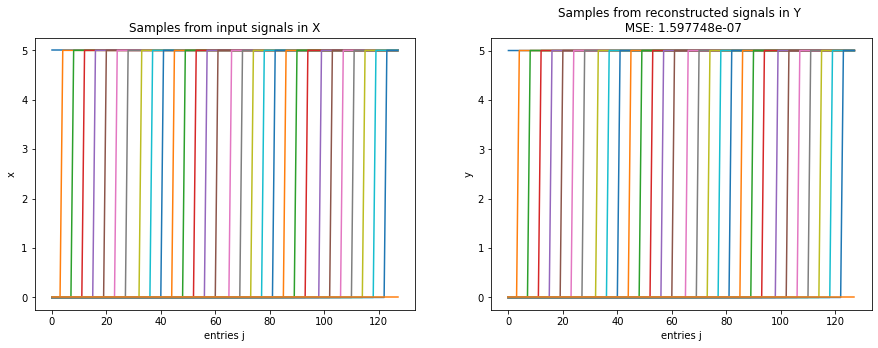

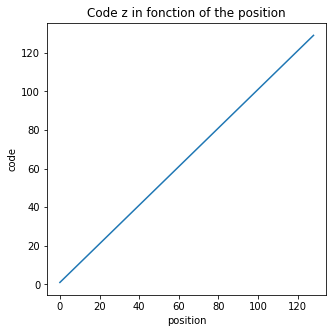

In [11]:
#Computing reconstructions and MSE loss
Y = ae.forward(X_test)
MSE_sigm_sol = torch.mean((Y-X_test)**2)

#Visualising the results
fig1 = plt.figure(figsize = (15,5))

axes = fig1.subplots(1,2)

for i in np.linspace(0, n, 32, dtype=int):
  axes[0].plot(X_test[i,:], label = i)
  axes[1].plot(Y[i].detach().numpy().ravel())

axes[0].set_title("Samples from input signals in X")
axes[1].set_title("Samples from reconstructed signals in Y \n MSE: {:e}".format(MSE_sigm_sol))

axes[0].set_xlabel("entries j")
axes[0].set_ylabel("x")

axes[1].set_xlabel("entries j")
axes[1].set_ylabel("y")

#Visualising the code in function of the position
fig2 = plt.figure(figsize = (5,5))
z = ae.encoder.code
plt.plot(z.detach().numpy())

plt.title("Code z in fonction of the position")
plt.xlabel("position")
plt.ylabel("code")

### Non monotonic encoding
We want to test the case of a non monotonic encoding with respect to the positions. 

Verified


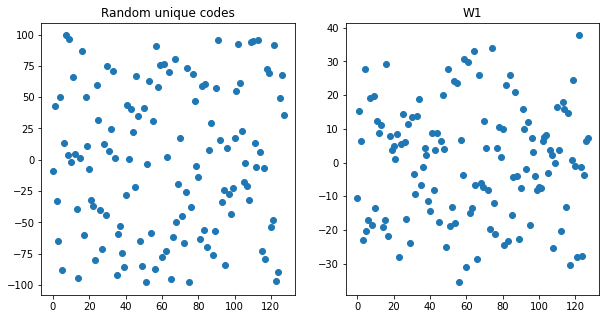

In [12]:
plt.figure(figsize=(10,5))

n=128

values = np.linspace(-100,100,300)

z_random_np = np.round(np.random.choice(values, n, replace = False),2)

#Generate n unique random codes
if np.unique(z_random_np).shape[0] != n:
  print("Problem")

z_random = torch.tensor(z_random_np, dtype=torch.float).unsqueeze(1)

#Plot the codes
plt.subplot(1,2,1)
plt.scatter(np.arange(n), z_random)
plt.title("Random unique codes")

#Compute W1 from z with b1=0
W1 = torch.empty((1,n))
W1[0,-1] = z_random[-1,0]
W1[0,:-1] = z_random[:-1,0] - z_random[1:,0]

W1 = W1/5.0

b1 = torch.tensor([[0.0]],dtype=torch.float)

plt.subplot(1,2,2)
plt.scatter(np.arange(n), W1.ravel())
plt.title("W1")

#Verifying W1
z = X_test[:-1] @ W1.T #We omit 0

if torch.allclose(z,z_random, rtol=1e-4, atol=1e-4):
  print("Verified")

if torch.unique(z).shape[0] != n:
  print("Error")

In [13]:
#First we sort the values of z
sort_ind = torch.argsort(z.ravel())

z_sorted = z[sort_ind]

#Then we compute k such that
k = torch.empty((1,n))
k[0,:-1] = -0.5 * (z_sorted[:-1,0] + z_sorted[1:,0])
k[0,-1] = -(z_sorted[-1] + 0.5)

#We choose W2 = [-1,-1,...,-1]
W2 = -torch.ones((n,1))
#Then b2 = k
b2 = torch.empty((1,n))
b2[0,sort_ind] = -k[0]

#We compute A2 that must be full rank
A2 = F.relu(z@W2.T+b2)

#We choose U3
U3 = -0.1 * torch.tril(torch.ones(n, n),diagonal=-1) + 5 * torch.triu(torch.ones(n, n))

#We compute W3
W3 = (torch.linalg.inv(A2)@U3).T

In [14]:
#Setting the computed weights for a linear encoder 
class fixed_Encoder(nn.Module):
  
  def __init__(self):
    super(fixed_Encoder, self).__init__()
    
    self.W1 = W1

    self.b1 = b1
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1, self.b1)
    
    return self.code

class fixed_Decoder(nn.Module):

  def __init__(self):
    super(fixed_Decoder, self).__init__()
    
    self.W2 = W2
    
    self.b2 = b2
    
    self.W3 = W3
    
  def forward(self, code):
    
    self.a2 = F.relu(F.linear(code, self.W2, self.b2))
    self.y = F.relu(F.linear(self.a2, self.W3))
    
    return self.y

In [15]:
n=128
#initializing the encoder and decoder
encoder = fixed_Encoder()
decoder = fixed_Decoder()

ae = AutoEncoder(encoder, decoder)

Text(0, 0.5, 'code')

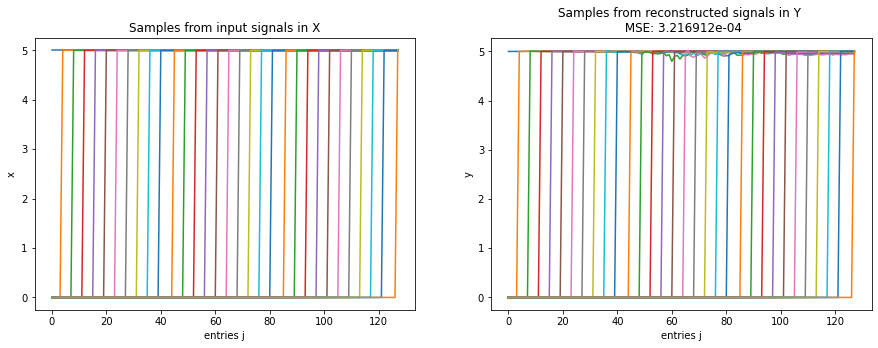

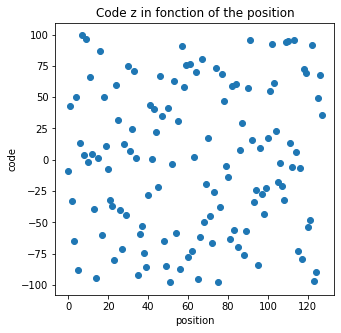

In [16]:
#Computing reconstructions and MSE loss
Y = ae.forward(X_test[:-1])
MSE_sigm_sol = torch.mean((Y-X_test[:-1])**2)

#Visualising the results
fig1 = plt.figure(figsize = (15,5))

axes = fig1.subplots(1,2)

for i in np.linspace(0, n-1, 32, dtype=int):
  axes[0].plot(X_test[i,:], label = i)
  axes[1].plot(Y[i].detach().numpy().ravel())

axes[0].set_title("Samples from input signals in X")
axes[1].set_title("Samples from reconstructed signals in Y \n MSE: {:e}".format(MSE_sigm_sol))

axes[0].set_xlabel("entries j")
axes[0].set_ylabel("x")

axes[1].set_xlabel("entries j")
axes[1].set_ylabel("y")

#Visualising the code in function of the position
fig2 = plt.figure(figsize = (5,5))
z = ae.encoder.code
plt.scatter(np.arange(z.shape[0]),z.detach().numpy())

plt.title("Code z in fonction of the position")
plt.xlabel("position")
plt.ylabel("code")

## Training Autoencoder with linear encoder

In [20]:
class linear_Encoder(nn.Module):
   
  def __init__(self, n_in, n_code):
    super(linear_Encoder, self).__init__()
    
    self.w = Parameter(torch.tensor([0.1], dtype= torch.float), requires_grad = True)

    self.W1 = torch.ones(n_code, n_in, dtype= torch.float)

    self.b1 = Parameter(torch.randn(1, n_code, dtype= torch.float)*0.1, requires_grad = True)
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1*self.w, self.b1)
    
    return self.code

class Decoder(nn.Module):
   
  def __init__(self, n_code, n_h1, n_out):
    super(Decoder, self).__init__()
    
    self.W2 = Parameter(torch.rand(n_h1, n_code, dtype= torch.float)*0.01, requires_grad = True)
    
    self.b2 = Parameter(torch.rand(1, n_h1, dtype= torch.float)*0.01, requires_grad = True)
    
    self.W3 = Parameter(torch.rand(n_out, n_h1, dtype= torch.float)*0.01, requires_grad = True)
    
  def forward(self, code):
    
    self.a2 = F.relu(F.linear(code, self.W2, self.b2))
    self.y = F.relu(F.linear(self.a2, self.W3))
    
    return self.y

In [23]:
n=128
encoder = linear_Encoder(n,1)
decoder = Decoder(1, n, n)

ae = AutoEncoder(encoder, decoder)

In [24]:
#Training
nb_epochs = 2500000 #Number of epochs
t=10000 #Each t epoch save the average losses over them

losses = [] #List to store the losses 
avg_loss = np.zeros(t) #Average losses on t epochs


alpha = 0.1e-5 #Learning rate

for epoch in range(nb_epochs):

  #Forward pass
  Y = ae.forward(X)
  
  #Compute the loss
  loss = torch.mean((Y-X)**2) 

  #Save current loss  
  avg_loss[epoch%t] = loss

  loss.backward()

  #Optimizer step
  ae.RMSprop_step(alpha = alpha, gamma = 0.9)

  if (epoch + 1 )%t == 0:

    print(f"epoch {epoch + 1} - loss: {avg_loss.mean()}") 

    losses.append(avg_loss.mean())
    

Init RMSprop
epoch 10000 - loss: 9.591372227478027
epoch 20000 - loss: 4.28664049847126
epoch 30000 - loss: 2.4840624616622926
epoch 40000 - loss: 2.4497496294498444
epoch 50000 - loss: 2.398834128332138
epoch 60000 - loss: 2.3337886508464813
epoch 70000 - loss: 2.2572523867607117
epoch 80000 - loss: 2.171964411020279
epoch 90000 - loss: 2.081195006799698
epoch 100000 - loss: 1.9881529747843742
epoch 110000 - loss: 1.8957919309735298
epoch 120000 - loss: 1.806751893401146
epoch 130000 - loss: 1.7233168326258659
epoch 140000 - loss: 1.6473182034373284
epoch 150000 - loss: 1.5800461613893508
epoch 160000 - loss: 1.5222077080607415
epoch 170000 - loss: 1.4738884754300117
epoch 180000 - loss: 1.4346057250499726
epoch 190000 - loss: 1.4031287173867226
epoch 200000 - loss: 1.3774398364663125
epoch 210000 - loss: 1.354908881151676
epoch 220000 - loss: 1.3338766593933105
epoch 230000 - loss: 1.313280218708515
epoch 240000 - loss: 1.293164460873604
epoch 250000 - loss: 1.2741819948554038
epoch 

(0.0, 10.065107134163975)

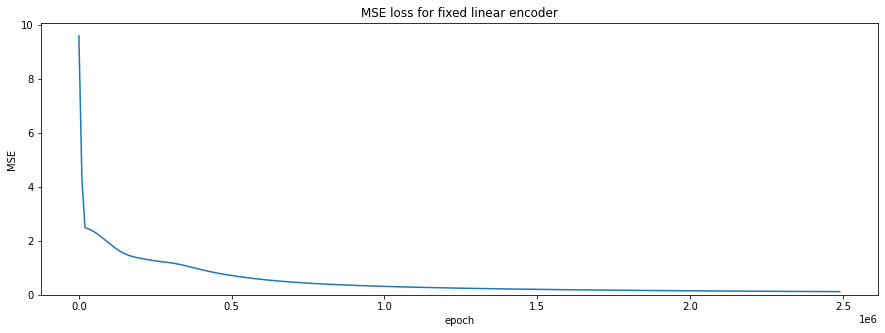

In [25]:
plt.figure(figsize=(15,5))

plt.plot(np.arange(len(losses))*t, losses)
plt.title("MSE loss for fixed linear encoder")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.ylim(ymin=0)

Text(0, 0.5, 'code')

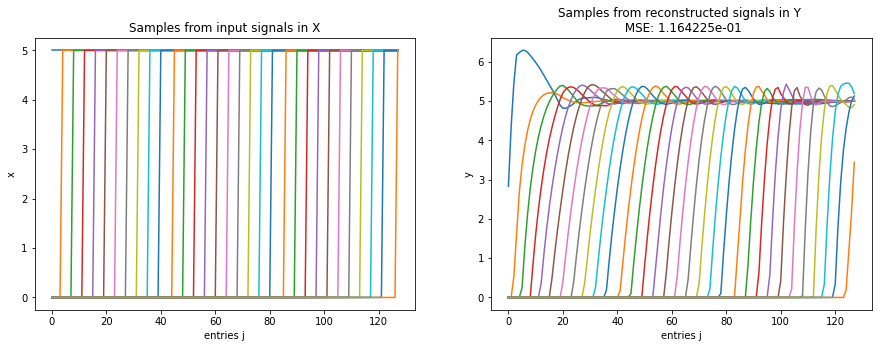

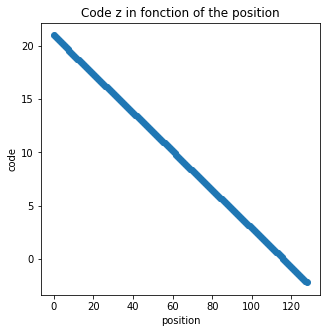

In [26]:
#Computing reconstructions and MSE loss
Y = ae.forward(X_test)
MSE_sigm_sol = torch.mean((Y-X_test)**2)

#Visualising the results
fig1 = plt.figure(figsize = (15,5))

axes = fig1.subplots(1,2)

for i in np.linspace(0, n-1, 32, dtype=int):
  axes[0].plot(X_test[i], label = i)
  axes[1].plot(Y[i].detach().numpy().ravel())

axes[0].set_title("Samples from input signals in X")
axes[1].set_title("Samples from reconstructed signals in Y \n MSE: {:e}".format(MSE_sigm_sol))

axes[0].set_xlabel("entries j")
axes[0].set_ylabel("x")

axes[1].set_xlabel("entries j")
axes[1].set_ylabel("y")

#Visualising the code in function of the position
fig2 = plt.figure(figsize = (5,5))
z = ae.encoder.code
plt.scatter(np.arange(z.shape[0]),z.detach().numpy())

plt.title("Code z in fonction of the position")
plt.xlabel("position")
plt.ylabel("code")


## Training Autoencoder with no constraints

In [27]:
class Encoder(nn.Module):
   
  def __init__(self, n_in, n_code):
    super(Encoder, self).__init__()

    self.W1 = Parameter(torch.rand(n_code, n_in, dtype= torch.float), requires_grad = True)

    self.b1 = Parameter(torch.randn(1, n_code, dtype= torch.float)*0.1, requires_grad = True)
    
  def forward(self, X):
    
    self.code = F.linear(X, self.W1, self.b1)
    
    return self.code

class Decoder(nn.Module):
   
  def __init__(self, n_code, n_h1, n_out):
    super(Decoder, self).__init__()
    
    self.W2 = Parameter(torch.rand(n_h1, n_code, dtype= torch.float)*0.01, requires_grad = True)
    
    self.b2 = Parameter(torch.rand(1, n_h1, dtype= torch.float)*0.01, requires_grad = True)
    
    self.W3 = Parameter(torch.rand(n_out, n_h1, dtype= torch.float)*0.01, requires_grad = True)
    
  def forward(self, code):
    
    self.a2 = F.relu(F.linear(code, self.W2, self.b2))
    self.y = F.relu(F.linear(self.a2, self.W3))
    
    return self.y

In [28]:
n=128
encoder = Encoder(n,1)
decoder = Decoder(1, n, n)

ae = AutoEncoder(encoder, decoder)

In [29]:
#Training
nb_epochs = 2500000 #Number of epochs
t=10000 #Each t epoch save the average losses over them

losses = [] #List to store the losses 
avg_loss = np.zeros(t) #Average losses on t epochs


alpha = 0.1e-4 #Learning rate

for epoch in range(nb_epochs):

  #Forward pass
  Y = ae.forward(X)
  
  #Compute the loss
  loss = torch.mean((Y-X)**2) 

  #Save current loss  
  avg_loss[epoch%t] = loss

  loss.backward()

  #Optimizer step
  ae.RMSprop_step(alpha = alpha, gamma = 0.9)

  if (epoch + 1 )%t == 0:

    print(f"epoch {epoch + 1} - loss: {avg_loss.mean()}") 

    losses.append(avg_loss.mean())
    

Init RMSprop
epoch 10000 - loss: 2.464209761083126
epoch 20000 - loss: 1.5876694699048997
epoch 30000 - loss: 1.2659499049663543
epoch 40000 - loss: 1.1252100634455682
epoch 50000 - loss: 1.034199866861105
epoch 60000 - loss: 0.965911552721262
epoch 70000 - loss: 0.9029775544822216
epoch 80000 - loss: 0.8334426753163338
epoch 90000 - loss: 0.7631670567035675
epoch 100000 - loss: 0.7061960133135319
epoch 110000 - loss: 0.6648535203695297
epoch 120000 - loss: 0.6323454923212528
epoch 130000 - loss: 0.6037714902758599
epoch 140000 - loss: 0.5776409705638885
epoch 150000 - loss: 0.5549841443181038
epoch 160000 - loss: 0.5351269025802612
epoch 170000 - loss: 0.5173718385219575
epoch 180000 - loss: 0.5012358871221543
epoch 190000 - loss: 0.486375451028347
epoch 200000 - loss: 0.47265443836152554
epoch 210000 - loss: 0.4600053123474121
epoch 220000 - loss: 0.44831900131702423
epoch 230000 - loss: 0.43746247327923776
epoch 240000 - loss: 0.42736984774470327
epoch 250000 - loss: 0.4179489307403

(0.0, 2.5834024597958476)

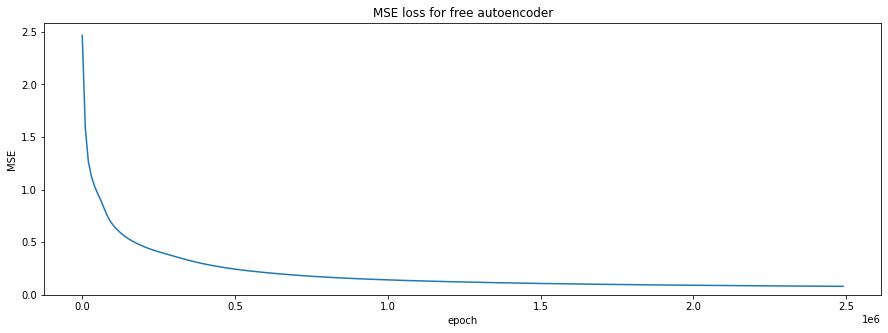

In [30]:
plt.figure(figsize=(15,5))

plt.plot(np.arange(len(losses))*t, losses)
plt.title("MSE loss for free autoencoder")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.ylim(ymin=0)

Text(0, 0.5, 'code')

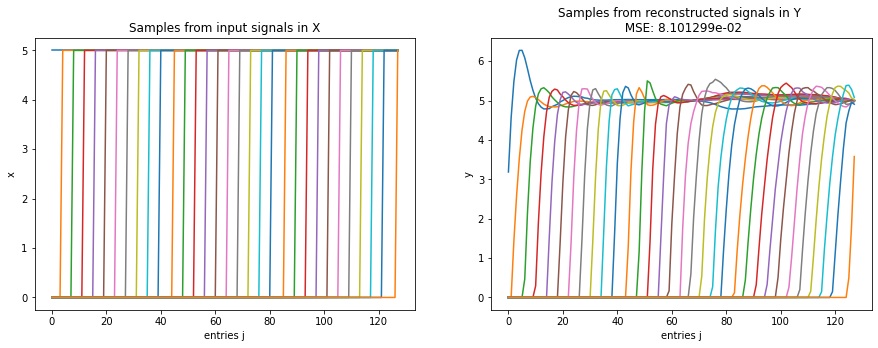

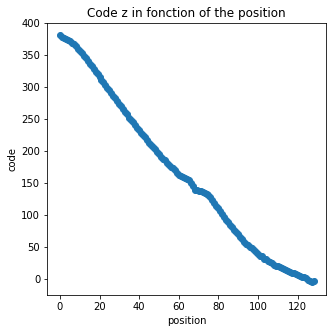

In [31]:
#Computing reconstructions and MSE loss
Y = ae.forward(X_test)
MSE_sigm_sol = torch.mean((Y-X_test)**2)

#Visualising the results
fig1 = plt.figure(figsize = (15,5))

axes = fig1.subplots(1,2)

for i in np.linspace(0, n-1, 32, dtype=int):
  axes[0].plot(X_test[i], label = i)
  axes[1].plot(Y[i].detach().numpy().ravel())

axes[0].set_title("Samples from input signals in X")
axes[1].set_title("Samples from reconstructed signals in Y \n MSE: {:e}".format(MSE_sigm_sol))

axes[0].set_xlabel("entries j")
axes[0].set_ylabel("x")

axes[1].set_xlabel("entries j")
axes[1].set_ylabel("y")

#Visualising the code in function of the position
fig2 = plt.figure(figsize = (5,5))
z = ae.encoder.code
plt.scatter(np.arange(z.shape[0]),z.detach().numpy())

plt.title("Code z in fonction of the position")
plt.xlabel("position")
plt.ylabel("code")